In [30]:
!pip install -r requirements.txt

  Cloning https://github.com/fpaissan/micromind to /tmp/pip-req-build-iwx5qhvp
  Running command git clone --filter=blob:none --quiet https://github.com/fpaissan/micromind /tmp/pip-req-build-iwx5qhvp
  Resolved https://github.com/fpaissan/micromind to commit 8d60ec970ccf19db2b802d96916897b6e7f76b34
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.cd import MMDDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

2025-03-06 14:15:51.557810: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 14:15:51.560903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 14:15:51.593775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 14:15:51.593812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 14:15:51.593835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# Load data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

170498071/170498071 [==============================] - 7s 0us/step


In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [6]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [7]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [8]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

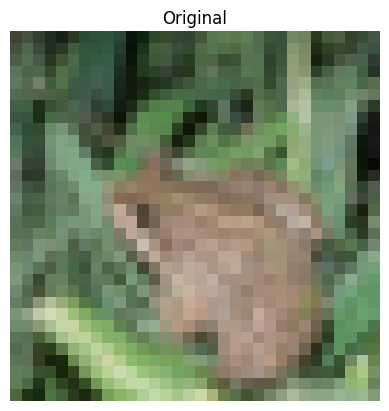

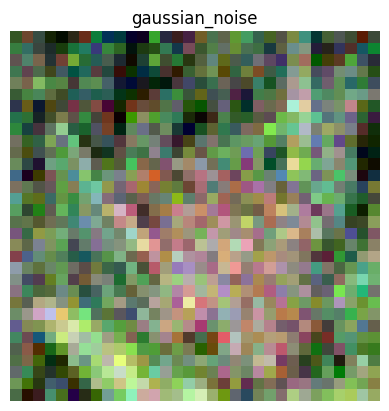

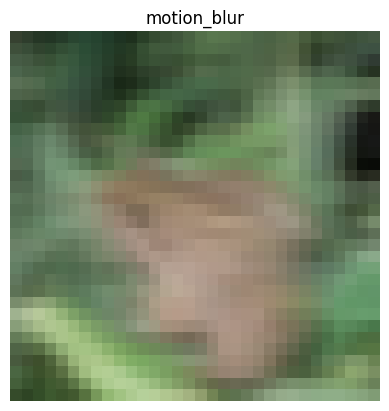

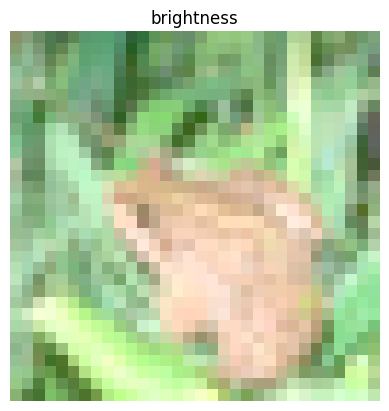

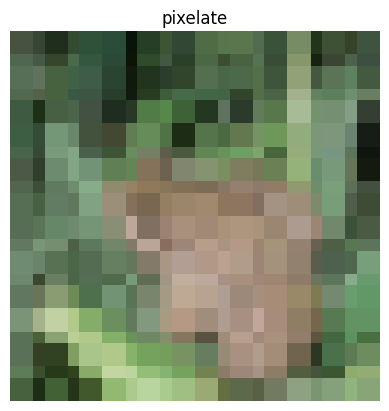

In [9]:
i = 4

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

# Detect drift with TensorFlow backend
drift detector using the TensorFlow framework for both the preprocessing and the MMD computation steps.

In [10]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
cd = MMDDrift(X_ref, backend='tensorflow', p_val=.05, 
              preprocess_fn=preprocess_fn, n_permutations=100)

# we can also save/load an initialised detector
filepath = 'detector_tf'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

Directory detector_tf does not exist and is now created.
Directory detector_tf/preprocess_fn/model does not exist and is now created.


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
            print(f'Time (s) {dt:.3f}')

In [12]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.260
Time (s) 23.897

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 52.973

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 52.843

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 52.284

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 52.262


In [25]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from alibi_detect.cd import MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector
from PIL import Image
import os

# Load CIFAR-10 dataset as the reference dataset
def load_cifar10_data():
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to a consistent size
        transforms.ToTensor(),        # Convert images to PyTorch tensors
    ])
    dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
    X_ref = next(iter(dataloader))[0].numpy()  # Extract the first batch of images
    return X_ref

# Load COCO8 dataset as the test dataset
def load_coco8_data(coco8_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to match CIFAR-10 size
        transforms.ToTensor(),        # Convert images to PyTorch tensors
    ])
    images = []
    for img_name in os.listdir(coco8_path):
        img_path = os.path.join(coco8_path, img_name)
        img = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)
        img = transform(img)
        images.append(img)
    X_test = torch.stack(images).numpy()  # Convert list of tensors to numpy array
    return X_test

# Load datasets
X_ref = load_cifar10_data()  # Reference dataset (CIFAR-10)
coco8_path = './data/coco8/images/train'       # Path to COCO8 dataset
X_test = load_coco8_data(coco8_path)  # Test dataset (COCO8)

# Initialize the MMD drift detector
mmd_detector = MMDDrift(
    X_ref,
    p_val=0.05,              # Significance level for drift detection
    backend='tensorflow',       # Use PyTorch backend
    n_permutations=100       # Number of permutations for p-value calculation
)

# Check for drift on the test data
preds = mmd_detector.predict(X_test)

# Output the results
print(f"Drift detected: {preds['data']['is_drift']}")
print(f"p-value: {preds['data']['p_val']}")
print(f"MMD statistic: {preds['data']['distance']}")
print(preds)

# Save the detector for future use
save_detector(mmd_detector, 'mmd_drift_detector')


# Load the detector (optional)
# loaded_detector = load_detector('mmd_drift_detector')

Drift detected: 0
p-value: 0.33
MMD statistic: 0.0025260448455810547
{'data': {'is_drift': 0, 'distance': 0.0025260448, 'p_val': 0.33, 'threshold': 0.05, 'distance_threshold': 0.04841125}, 'meta': {'name': 'MMDDriftTF', 'online': False, 'data_type': None, 'version': '0.12.0', 'detector_type': 'drift', 'backend': 'tensorflow'}}
